In [1]:
import csv
import os
from math import log10, inf
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
class Kind(Enum):
    Acc = 'accuracy.csv'
    Mem = 'mem-ideal.csv'
    Perf = 'perf.csv'
    Per_particle = 'per-particles.csv'
    Per_step = 'per-step.csv'
    Per_step_mem = 'per-step-mem.csv'
    Perf_step = 'perf-step.csv'
    
class Algo(Enum):
    # DS = 'ds_nogc'
    BDS = 'ds_bounded'
    SDS = 'ds'
    PF = 'particles'
    
class Example(Enum):
    BetaBernoulli = 'coin'
    Gaussian = 'gaussian'
    Kalman = 'kalman'
    Outlier = 'outlier'
    Robot = 'tracker'
    Slam = 'slam'
    Mtt = 'mtt'
    
class Data:
    def __init__(self, example, algo, kind):
        self.filename = os.path.join('..', example.value, algo.value, kind.value)
        self.file = None
        
    def __enter__(self):
        self.file = open(self.filename, 'r')
        header = [h.strip() for h in self.file.readline().split(',')]
        return csv.DictReader(self.file, fieldnames=header, quoting=csv.QUOTE_NONNUMERIC)
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.file.close()

In [3]:
def get_baseline(example, algo=Algo.SDS, particles=500):
    with Data(example, algo, Kind.Acc) as accuracy, Data(example, algo, Kind.Perf) as perf:
        acc = next(row['median'] for row in accuracy if row['particles'] == particles)
        perf = next(row['median'] for row in perf if row['particles'] == particles)
        return acc, perf

In [4]:
def get_crossing_point(example, algo, baseline={}):
    b_acc, b_perf = get_baseline(example, **baseline)
    with Data(example, algo, Kind.Acc) as accuracy, Data(example, algo, Kind.Perf) as perf:
        try:
            cond = lambda x: abs(log10(x) - log10(b_acc)) <= 0.5
            particles = next(row['particles'] for row in accuracy if cond(row['upper quantile']))
            lower, median, upper = next(
                (row['time in ms lower quantile'], row['median'], row['upper quantile'])
                for row in perf if row['particles'] == particles)
        except StopIteration:
            cond = lambda x: x >= b_perf * 10.
            particles, lower, median, upper = next(
                (-row['particles'], row['time in ms lower quantile'], row['median'], row['upper quantile'])  
                for row in perf if cond(row['median']))
        return particles, lower, median, upper

In [5]:
def get_results(baseline={}):
    res = {}
    for example in Example:
        res[example.name] = {}
        for algo in Algo:
            try:
                (particles, lower, median, upper) = get_crossing_point(example, algo, baseline)
            except (StopIteration, IOError):
                (particles, lower, mean, upper) = 0, 0, 0, 0
            res[example.name][algo.name] = {
                'particles': particles,
                'lower': lower,
                'median': median,
                'upper': upper }
    return res

In [6]:
def plot(results): 
    barWidth = 0.25
 
    bars1 = [results[ex.name]['PF']['median'] for ex in Example]
    bars2 = [results[ex.name]['BDS']['median'] for ex in Example]
    bars3 = [results[ex.name]['SDS']['median'] for ex in Example]
 
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
 
    plt.bar(r1, bars1, width=barWidth, edgecolor='white', alpha=0.75)
    plt.bar(r2, bars2, width=barWidth, edgecolor='white', alpha=0.75)
    plt.bar(r3, bars3, width=barWidth, edgecolor='white', alpha=0.75)
 
    plt.xticks([r + barWidth for r in range(len(bars1))], [ex.name for ex in Example])
    plt.yscale('log')
    plt.xticks(rotation=30)
    
    plt.show()

{'BetaBernoulli': {'BDS': 200.0, 'PF': 200.0, 'SDS': 1.0},
 'Gaussian': {'BDS': 750.0, 'PF': 3000.0, 'SDS': 150.0},
 'Kalman': {'BDS': 1.0, 'PF': 15.0, 'SDS': 1.0},
 'Mtt': {'BDS': 0, 'PF': 4500.0, 'SDS': 45.0},
 'Outlier': {'BDS': 65.0, 'PF': 650.0, 'SDS': 65.0},
 'Robot': {'BDS': 8.0, 'PF': 85.0, 'SDS': 1.0},
 'Slam': {'BDS': -6500.0, 'PF': -15000.0, 'SDS': 700.0}}


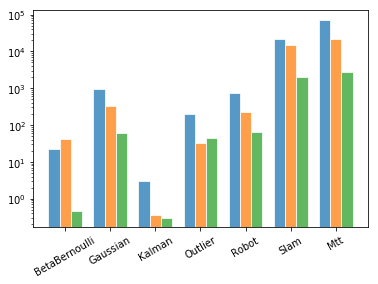

In [7]:
results = get_results()
pprint({ex: {algo: results[ex][algo]['particles'] for algo in results[ex]} for ex in results})
plot(results)

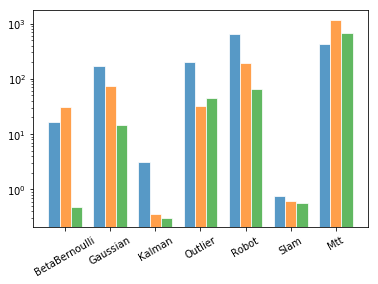

In [8]:
plot(get_results({'algo': Algo.PF, 'particles': 1000}))

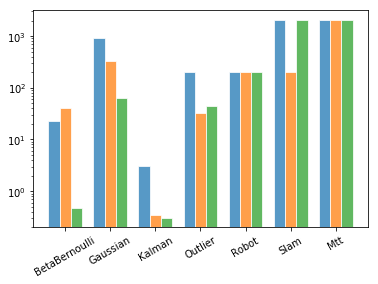

In [9]:
plot(get_results({'algo': Algo.PF, 'particles': 10000}))

In [10]:
def algo_to_pgf(results, algo):
    exs = {'BetaBernoulli': 'Beta-Bernoulli',
           'Gaussian': 'Gaussian-Gaussian',
           'Kalman': 'Kalman-1D',
           'Outlier': 'Outlier',
           'Robot': 'Robot',
           'Slam': 'SLAM',
           'Mtt': 'MTT' }
    print("x\ty\ty-min\ty-max\tp")
    for x in results:
        y = results[x][algo.name]['median']
        y_max = results[x][algo.name]['upper'] -  y
        y_min = y - results[x][algo.name]['lower']
        p = int(results[x][algo.name]['particles'])
        if p >= 0:
            print(f"{exs[x]}\t{y}\t{y_min}\t{y_max}\t{p:,d}")
        else:
            print(f"{exs[x]}\t{200000}\t{0.0}\t{0.0}\t{{> {-p:,d}\phantom{{X}}}}")
            
        
def to_pgf(results):
    algs = {'PF': '\particles', 'SDS': '\sds', 'BDS': '\\bds'}
    for algo in Algo:
        print("\pgfplotstableread{")
        algo_to_pgf(results, algo)
        print(f"}}{{{algs[algo.name]}}}\n")

In [11]:
to_pgf(results)

\pgfplotstableread{
x	y	y-min	y-max	p
Beta-Bernoulli	40.965897	0.7262259999999969	1.0591480000000004	200
Gaussian-Gaussian	331.4194	11.802225000000021	9.193825000000004	750
Kalman-1D	0.351831	0.0018060000000000298	0.025310999999999972	1
Outlier	32.408477	0.3080449999999999	0.972565000000003	65
Robot	225.480535	7.782234000000017	20.335026	8
SLAM	200000	0.0	0.0	{> 6,500\phantom{X}}
MTT	21279.041365	21279.041365	-21279.041365	0
}{\bds}

\pgfplotstableread{
x	y	y-min	y-max	p
Beta-Bernoulli	0.478769	0.01849400000000001	0.08760500000000004	1
Gaussian-Gaussian	62.674843	2.6271850000000043	2.361094999999999	150
Kalman-1D	0.309388	0.006307000000000007	0.021992999999999985	1
Outlier	44.302562	0.7344000000000008	2.684731999999997	65
Robot	66.467892	2.241127000000006	19.212818	1
SLAM	2066.227669	376.7682419999999	377.5444080000002	700
MTT	2717.556621	453.6930390000002	747.346642	45
}{\sds}

\pgfplotstableread{
x	y	y-min	y-max	p
Beta-Bernoulli	22.350183	0.615006000000001	1.002883999999998	200
Gauss